In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
reviews = pd.read_csv('user_courses_review_09_2023.csv', on_bad_lines='skip')
reviews

,course_name,lecture_name,review_rating,review_comment
0,A/B Testing in Python,How to set up the A/B test,5,If she could provide more details about the pr...
1,A/B Testing in Python,How to set up the A/B test,5,nice
2,A/B Testing in Python,How to set up the A/B test,5,excellent course
3,A/B Testing in Python,How to set up the A/B test,5,nice
4,A/B Testing in Python,Conclusion,5,It was an experiential learning process
...,...,...,...,...
10837,Working with Text Files in Python,Working with Text Files - Conclusion,5,This course was very informative and had a lot...
10838,Working with Text Files in Python,Principles of Importing Data in Python,5,On to the point
10839,Working with Text Files in Python,Principles of Importing Data in Python,5,loving it
10840,Working with Text Files in Python,Principles of Importing Data in Python,5,Good course


In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10842 entries, 0 to 10841
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   course_name     10842 non-null  object
 1   lecture_name    10832 non-null  object
 2   review_rating   10828 non-null  object
 3   review_comment  10639 non-null  object
dtypes: object(4)
memory usage: 338.9+ KB


In [ ]:
#reviews['review_rating'] = reviews['review_rating'].astype(float)
#type(reviews['review_rating'])
unique_reviews = reviews['review_rating'].unique()
unique_reviews

array(['5', '4', '3', '2', '1', nan,
       " but I don't like the presenting style. There are visually better videos on this platform",
       ' VLOOKUP',
       ' show me the expected output from SQL so I can check my output and troubleshoot before peeking at the code."',
       ' Bridge round'], dtype=object)

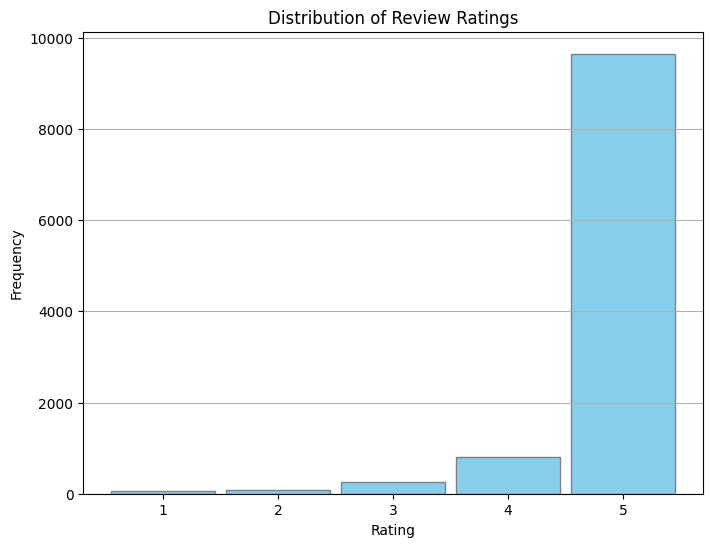

count    10824.000000
mean         4.840632
std          0.525791
min          1.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_rating, dtype: float64

In [25]:
# Prepare review ratings
reviews['review_rating'] = pd.to_numeric(reviews['review_rating'], errors='coerce')
rating_counts = reviews['review_rating'].value_counts().sort_index()
rating_counts.head()

# Summary statistics for 'review_rating'
review_rating_stats = reviews['review_rating'].describe()

# Distribution of 'review_rating'
plt.figure(figsize=(8, 6))
plt.hist(reviews['review_rating'].dropna(), bins=range(1, 7), align='left', rwidth=0.9, color='skyblue', edgecolor='gray')
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.grid(axis='y')
plt.show()

review_rating_stats

(10637, 5)

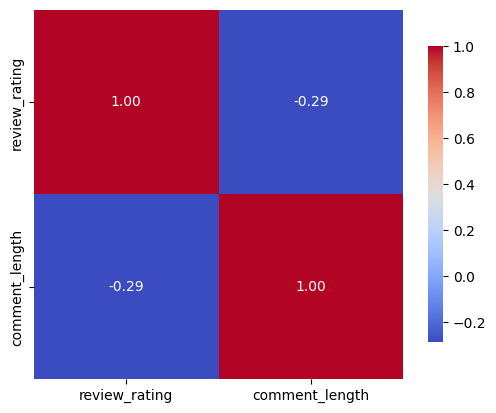

In [31]:
# Remove rows with missing values
clean_data = reviews.dropna().reset_index()

# Check the new shape of the data
new_shape = clean_data.shape

# For correlation analysis, we first need to add a new column for the length of the comments
clean_data['comment_length'] = clean_data['review_comment'].apply(len)

# Calculate the correlation between 'review_rating' and 'comment_length'
correlation = clean_data[['review_rating', 'comment_length']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
new_shape 


In [32]:
import re

# Define regex patterns to look for emphasis and sentiment
patterns = {
    "positive_emphasis": re.compile(r'\b(great|good|excellent|amazing|love|best|awesome|fantastic)\b', re.IGNORECASE),
    "negative_emphasis": re.compile(r'\b(bad|terrible|awful|poor|worst|hate|disappoint)\b', re.IGNORECASE),
    "question": re.compile(r'\?'),
    "exclamation": re.compile(r'!'),
    "capital_words": re.compile(r'\b[A-Z]{2,}\b')  # words with all letters capitalized, and at least two characters long
}

# Initialize a dictionary to hold the counts of each pattern
pattern_counts = {key: 0 for key in patterns}

# Scan each review and count the occurrences of each pattern
for review in clean_data['review_comment']:
    for key, pattern in patterns.items():
        if re.search(pattern, review):
            pattern_counts[key] += 1

pattern_counts


{'positive_emphasis': 6147,
 'negative_emphasis': 23,
 'question': 31,
 'exclamation': 1180,
 'capital_words': 535}

In [33]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10637 entries, 0 to 10636
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           10637 non-null  int64  
 1   course_name     10637 non-null  object 
 2   lecture_name    10637 non-null  object 
 3   review_rating   10637 non-null  float64
 4   review_comment  10637 non-null  object 
 5   comment_length  10637 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 498.7+ KB


## Modelliing
In the first trial at modelling It looks like the major class Imbalance will be a Obstruction to our Goal

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import string

# Function for text cleaning and normalization
def clean_text(text):
    text = text.lower()  # convert text to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    return text

# Apply the function to clean the reviews
clean_data.loc[:, 'review_comment'] = clean_data.loc[:, 'review_comment'].apply(clean_text)

# Split data into features (X) and target label (y)
X = clean_data.loc[:, 'review_comment']
y = clean_data.loc[:, 'review_rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025, stratify=y)



In [70]:
# Initialize a TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Initialize the Multinomial Naive Bayes classifier
model = MultinomialNB()

# Create a pipeline that first vectorizes the text data then applies the Naive Bayes classifier
text_clf = make_pipeline(vectorizer, model)

# Fit the model on the training data
text_clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = text_clf.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5]))


Classification Report:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         9
         2.0       0.00      0.00      0.00        15
         3.0       0.00      0.00      0.00        49
         4.0       0.00      0.00      0.00       153
         5.0       0.89      1.00      0.94      1902

    accuracy                           0.89      2128
   macro avg       0.18      0.20      0.19      2128
weighted avg       0.80      0.89      0.84      2128

Confusion Matrix:
 [[   0    0    0    0    9]
 [   0    0    0    0   15]
 [   0    0    0    0   49]
 [   0    0    0    0  153]
 [   0    0    0    0 1902]]


c:\Users\useer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\useer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\useer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [76]:
from sklearn.utils import resample

# Separate the majority and minority classes
df_majority = clean_data[clean_data.review_rating == 5]
df_minority = clean_data[clean_data.review_rating < 5]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=2025) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display old and new class counts
print(clean_data.review_rating.value_counts(),
    df_upsampled.review_rating.value_counts())


review_rating
5.0    9505
4.0     765
3.0     245
2.0      75
1.0      47
Name: count, dtype: int64 review_rating
5.0    9505
4.0    6512
3.0    2018
2.0     603
1.0     372
Name: count, dtype: int64


In [83]:
# Split the upsampled data into features (X) and target label (y)
X_upsampled = df_upsampled['review_comment']
y_upsampled = df_upsampled['review_rating']

# Split the upsampled data into training and testing sets
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(
    X_upsampled, y_upsampled, test_size=0.2, random_state=42)

# Train the model with the upsampled training data
text_clf_upsampled = make_pipeline(vectorizer, model)
text_clf_upsampled.fit(X_train_upsampled, y_train_upsampled)

# Predict the categories of the upsampled test data
y_pred_upsampled = text_clf_upsampled.predict(X_test_upsampled)

# Calculate the classification report for the upsampled data
report_upsampled = classification_report(y_test_upsampled, y_pred_upsampled)

# Calculate the confusion matrix for the upsampled data
conf_matrix_upsampled = confusion_matrix(y_test_upsampled, y_pred_upsampled)

print(report_upsampled , conf_matrix_upsampled)


              precision    recall  f1-score   support

         1.0       1.00      0.27      0.42        89
         2.0       1.00      0.32      0.48       123
         3.0       0.97      0.59      0.73       377
         4.0       0.70      0.66      0.68      1317
         5.0       0.76      0.91      0.83      1896

    accuracy                           0.76      3802
   macro avg       0.88      0.55      0.63      3802
weighted avg       0.77      0.76      0.75      3802
 [[  24    0    4   47   14]
 [   0   39    3   69   12]
 [   0    0  222   91   64]
 [   0    0    0  871  446]
 [   0    0    1  175 1720]]
